# Embrace Randomness - in XGBoost

**IMPORTANT:** XGBoost is deterministic when the model parameters *subsample* and *colsample_by_** are set to the default values of 1.0.

Thus, running XGBoost with the default parameters will always return the same model (given the same training set as input). Even changing XGBoost's random state has no effect in this case - because it only comes into play when sampling is used.

However, to prevent overfitting it is common to test different values for the sampling parameters (e.g. during hyperparameter optimization). Consequently, XGBoost will generate different models for the same input data when trained repeatedly.

There are two ways to deal with the randomness:

1. set *random_state* to a fixed value - this is good for reproducability, but **not for production-ready models!** (TODO: add reference)
2. train the model many times with cross validation and choose the model with the highest mean score as final model, i.e. the model which achieves the best generalization on the given training and test data.

## Overview

In this notebook, we will

* Train XGBoost with default parameters (produces deterministic model).
* Train XGBoost with resampling (produces random model).
* Train XGBoost with cross validation.

## Pre-requisites

* Load dataset (breast cancer - clean data, no missing values, no features engineering necessary)
* Split into training and test data (70%/30%)

In [1]:
from time import time
import numpy as np
import pandas as pd
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = datasets.load_breast_cancer()

# IMPORTANT: switch target labels as malignant should be 1

X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = 1-pd.Series(data['target'], name='target')

labels = data['target_names'][[1,0]]

# Split training and test data

In [3]:
from sklearn.model_selection import train_test_split

random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=random_seed)
print("train: ", X_train.shape, ', test:', X_test.shape)

train:  (398, 30) , test: (171, 30)


# Train XGBoost Models

## Deterministic Model: using default parameters

In [4]:
max_rounds = 100   # maximum number of boosting iterations
early_stop = 50    # stop if metric does not improve for X rounds

In [5]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

def train_xgb_sklearn(params, X_train, y_train, X_test, y_test, random_seed):
    '''Train and predict with Scikit-Learn XGBClassifier'''
    clf = XGBClassifier(n_estimators=max_rounds, **params, random_state=random_seed)
    clf.fit(X_train, y_train)
    return clf.predict_proba(X_test)[:,1]

def train_xgb_native(params, X_train, y_train, X_test, y_test, random_seed):
    '''Train '''
    params = {**params, 'seed':random_seed}
    train = xgb.DMatrix(X_train.values, y_train.values)
    test  = xgb.DMatrix(X_test.values, y_test.values)
    bst = xgb.train(params, train, max_rounds)
    return bst.predict(test)

In [6]:
def eval_metrics(y_true, y_hat):
    return {
        'auc': roc_auc_score(y_true, y_hat),
        'acc': accuracy_score(y_true, y_hat >= 0.5),
        'wrong': y_true[y_true != (y_hat >= 0.5)].index.values,
    }

def eval_n_times(n, xgb_train, params, verbose=True):
    print(f"RUNNING {n}-times '{xgb_train.__name__}' with {params}")
    results=[]
    for i in range(n):
        random_seed = np.random.randint(1000)
        y_hat = xgb_train(params, X_train, y_train, X_test, y_test, random_seed)
        metrics = {**eval_metrics(y_test, y_hat), 'seed':random_seed}
        results.append(metrics)
        if verbose:
            print("roc_auc={auc:.4f}, accuracy={acc:.4f}, wrong:{wrong}, seed:{seed}".format(**metrics))
    return results

In [7]:
# using default XGBoost parameters
# 'max_depth' and 'learning_rate' have to be set because xgb.train() and XGBClassifier use different defaults
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'learning_rate':0.1
}

for fun in [train_xgb_sklearn, train_xgb_native]:
    eval_n_times(3, fun, params);

RUNNING 3-times 'train_xgb_sklearn' with {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1}
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:926
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:859
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:286
RUNNING 3-times 'train_xgb_native' with {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1}
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:324
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:80
roc_auc=0.9949, accuracy=0.9649, wrong:[205   5  86 193  73 385], seed:326


## Random Model - using subsample parameter

In [8]:
# using subsample in XGBoost parameters
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'learning_rate':0.1,
    'subsample':0.8,
}

for fun in [train_xgb_sklearn, train_xgb_native]:
    results = eval_n_times(5, fun, params);
    print("MEAN: roc_auc={auc:.4f}, accuracy={acc:.4f}\n".format(**pd.DataFrame(results).mean().to_dict()))

RUNNING 5-times 'train_xgb_sklearn' with {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
roc_auc=0.9947, accuracy=0.9708, wrong:[205  86 193  73 385], seed:612
roc_auc=0.9955, accuracy=0.9825, wrong:[ 86  73 385], seed:468
roc_auc=0.9952, accuracy=0.9708, wrong:[205  86 193  73 385], seed:794
roc_auc=0.9966, accuracy=0.9825, wrong:[205  73 385], seed:272
roc_auc=0.9955, accuracy=0.9708, wrong:[205  86 193  73 385], seed:266
MEAN: roc_auc=0.9955, accuracy=0.9754

RUNNING 5-times 'train_xgb_native' with {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
roc_auc=0.9956, accuracy=0.9708, wrong:[205  86 193  73 385], seed:741
roc_auc=0.9959, accuracy=0.9766, wrong:[205  86  73 385], seed:415
roc_auc=0.9947, accuracy=0.9766, wrong:[ 86 193  73 385], seed:491
roc_auc=0.9956, accuracy=0.9825, wrong:[ 86  73 385], seed:885
roc_auc=0.9963, accuracy=0.9766, wrong:[  5  86  73 385], seed:302
MEAN: roc_auc=0.9956, accura

# Cross Validation without Early Stopping (OLD)

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from joblib import Parallel, delayed

# not possible to use early stopping with sklearn cross validate
def train_xgb_cv_sklearn(X_train, y_train, params, max_rounds, skb, random_seed):
    clf = XGBClassifier(n_estimators=max_rounds, **params, random_state=random_seed)
    results = cross_validate(clf, X_train, y_train, cv=skb, scoring=['roc_auc', 'accuracy'], n_jobs=4, return_train_score=False)
    roc, acc = pd.DataFrame(results).mean()[['test_roc_auc', 'test_accuracy']].values
    return {'auc':roc, 'acc':acc}

def train_xgb_cv_native(X_train, y_train, params, max_rounds, skb, random_seed):
    params = {**params, 'seed':random_seed}
    train = xgb.DMatrix(X_train.values, y_train.values)
    result = xgb.cv(params, train, max_rounds, folds=skb, metrics=['error','auc'])
    roc, err = result.iloc[-1][['test-auc-mean', 'test-error-mean']].values
    return {'auc':roc, 'acc':1-err}

def train_xgb_cv_custom(X_train, y_train, params, max_rounds, skb, random_seed):
    fold_results=[]
    params = {**params, 'seed':random_seed}
    train = xgb.DMatrix(X_train.values, y_train.values)
    for i,s in enumerate(skb.split(X_train,y_train)):
        fold_train = train.slice(s[0])
        fold_test  = train.slice(s[1])
        bst = xgb.train(params, fold_train, max_rounds)
        #xgb.train(params, train, max_rounds, evals=[(test, 'validation_0')], verbose_eval=True)
        y_hat = bst.predict(fold_test)
        metrics = eval_metrics(y_train.iloc[s[1]], y_hat)
        fold_results.append(metrics)
    return pd.DataFrame(fold_results).mean().to_dict()

def eval_n_times_cv(xgb_cv, X_train, y_train, n, params, nfold=5, verbose=True):
    print(f"RUNNING {n}x {nfold}-fold '{xgb_cv.__name__}' with {params}")
    results = []
    start = time()
    rs = np.random.RandomState(42)
    for i in range(n):
        random_seed = rs.randint(1000)
        skb = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=random_seed)
        metrics = xgb_cv(X_train, y_train, params, max_rounds, skb, random_seed)
        results.append(metrics)
        metrics = {**metrics, 'seed':random_seed}
        if (verbose != 0) & (i % verbose == 0):
            print(f"{i}:", "roc_auc={auc:.4f}, accuracy={acc:.4f}, seed={seed}".format(**metrics))

    print("took %.1f seconds" % (time() - start))
    return results

In [10]:
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'learning_rate':0.1
}

results = eval_n_times_cv(train_xgb_cv_sklearn, X_train, y_train, 100, params, verbose=10)
print("MEAN: roc_auc={auc:.4f}, accuracy={acc:.4f}\n".format(**pd.DataFrame(results).mean().to_dict()))

results = eval_n_times_cv(train_xgb_cv_native, X_train, y_train, 30, params, verbose=10)
print("MEAN: roc_auc={auc:.4f}, accuracy={acc:.4f}\n".format(**pd.DataFrame(results).mean().to_dict()))

results = eval_n_times_cv(train_xgb_cv_custom, X_train, y_train, 100, params, verbose=10)
print("MEAN: roc_auc={auc:.4f}, accuracy={acc:.4f}\n".format(**pd.DataFrame(results).mean().to_dict()))

RUNNING 100x 5-fold 'train_xgb_cv_sklearn' with {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1}
0: roc_auc=0.9920, accuracy=0.9673, seed=102
10: roc_auc=0.9909, accuracy=0.9574, seed=466
20: roc_auc=0.9872, accuracy=0.9623, seed=661
30: roc_auc=0.9882, accuracy=0.9547, seed=276
40: roc_auc=0.9880, accuracy=0.9498, seed=58
50: roc_auc=0.9883, accuracy=0.9548, seed=957
60: roc_auc=0.9882, accuracy=0.9648, seed=646
70: roc_auc=0.9923, accuracy=0.9649, seed=776
80: roc_auc=0.9901, accuracy=0.9674, seed=508
90: roc_auc=0.9930, accuracy=0.9623, seed=1
took 20.6 seconds
MEAN: roc_auc=0.9898, accuracy=0.9577

RUNNING 30x 5-fold 'train_xgb_cv_native' with {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1}
0: roc_auc=0.9920, accuracy=0.9673, seed=102
10: roc_auc=0.9909, accuracy=0.9574, seed=466
20: roc_auc=0.9872, accuracy=0.9623, seed=661
took 25.1 seconds
MEAN: roc_auc=0.9901, accuracy=0.9591

RUNNING 100x 5-fold 'train_xgb_cv_custom' with {'objectiv

# Early Stopping with Cross Validation (only native XGBoost)

Early stopping (of model training) helps to prevent overfitting and cross validation limits the bias of a specific training set.

**CAUTION:** 

* Scikit-Learn does not support cross validation with early stopping (because early stopping needs the left-out validation set from the created folds, but they are not accessible)
* There is a [bug when using multiple eval metrics](https://github.com/dmlc/xgboost/pull/4638) - it was fixed in July 2019 in xgboost 0.??

In [11]:
# using default parameters
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'learning_rate':0.1,
    'nthread':4,
}

nfold=5
max_rounds=500
early_stop=20   # better use small values to avoid overfitting

In [12]:
train = xgb.DMatrix(X_train.values, y_train.values)
test  = xgb.DMatrix(X_test.values, y_test.values)

In [13]:
# two ways for cross validations with early stopping - with identical results

def best_cv_native(params, train, max_rounds, nfold, metrics, early_stop, random_seed=0):
    results = xgb.cv(params, train, max_rounds, nfold, stratified=True, metrics=metrics, early_stopping_rounds=early_stop, seed=random_seed)
    values = results[[f'test-{m}-mean' for m in metrics]].reset_index().values[-1]
    return {k:v for k,v in zip(['best_round'] + metrics, values)}

def best_cv_native_skb(params, train, max_rounds, nfold, metrics, early_stop, random_seed=0):
    skb = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=random_seed)
    results = xgb.cv(params, train, max_rounds, folds=skb, metrics=metrics, early_stopping_rounds=early_stop, seed=random_seed)
    values = results[[f'test-{m}-mean' for m in metrics]].reset_index().values[-1]
    return {k:v for k,v in zip(['best_round'] + metrics, values)}

In [14]:
# sanity check: both methods must return same results
for metric in [['logloss'], ['auc'], ['error']]:
    print('fun-1:', best_cv_native(params, train, max_rounds, 5, metric, 20))
    print('fun-2:', best_cv_native_skb(params, train, max_rounds, 5, metric, 20))

fun-1: {'best_round': 128.0, 'logloss': 0.1119114}
fun-2: {'best_round': 128.0, 'logloss': 0.1119114}
fun-1: {'best_round': 46.0, 'auc': 0.9899908}
fun-2: {'best_round': 46.0, 'auc': 0.9899908}
fun-1: {'best_round': 13.0, 'error': 0.055443}
fun-2: {'best_round': 13.0, 'error': 0.055443}


## Cross Validation with early stopping

In [15]:
def cv_n_times(n, params, train, max_rounds, nfold, metrics, early_stop):
    '''Execute cross validation n-times with randomly split folds.'''
    print(f"RUNNING {n}x CV: {nfold}-fold, {max_rounds}({early_stop}) rounds, {metrics}, {params}")
    cv_results = []
    rs = np.random.RandomState(42)
    
    start = time()
    for i in range(n):
        random_seed = rs.randint(1000)
        res = best_cv_native(params, train, max_rounds, nfold, metrics, early_stop, random_seed=random_seed)
        cv_results.append({**res, 'seed':random_seed})
    print("took %.1f seconds" % (time() - start))
    return pd.DataFrame(cv_results)

def score_test(params, train, test, rounds, metrics=['auc']):
    print(f"EVALUATING test set: {metrics}")
    test_results = []
    start = time()
    for max_round in rounds.astype(int):
        evals_result = {}
        xgb.train({**params, 'eval_metric': metrics}, train, max_round+1, evals=[(test, 'test')], evals_result=evals_result, verbose_eval=False)
        values = pd.DataFrame(evals_result['test'])[metrics].values[-1]
        test_results.append({k:v for k,v in zip(metrics, values)})
    print("took %.1f seconds" % (time() - start))
    return pd.DataFrame(test_results)

def joint_plot(x, y, title=None):
    g = sns.jointplot(x, y, kind="kde", space=0, n_levels=100, cmap='coolwarm')
    #g.ax_joint.axhline(y=df_cv.best_score.median()*100, color='lightblue', linestyle='--')
    #g.ax_joint.axvline(x=df_cv.best_round.median(), color='lightblue', linestyle='--')
    g.plot_joint(plt.scatter, c="k", s=1, linewidth=1)
    g.fig.suptitle(title)
    g.fig.subplots_adjust(top=0.95)

In [16]:
def eval_cv_tests(params, train, test, max_rounds, nfold, metrics, early_stop, n_times=100):
    df_cv_res = cv_n_times(n_times, params, train, max_rounds, nfold, metrics, early_stop)
    test_scores = score_test(params, train, test, df_cv_res.best_round, metrics)
    df_all = df_cv_res.assign(test_score=test_scores[metrics[-1]])
    if metrics[-1] == 'auc':
        df_all.test_score = df_all.test_score * 100

    joint_plot(df_all.best_round, df_all[metrics[-1]])
    joint_plot(df_all[metrics[-1]], df_all.test_score)
    joint_plot(df_all.best_round, df_all.test_score)

RUNNING 100x CV: 5-fold, 500(20) rounds, ['auc'], {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1, 'nthread': 4}
took 49.7 seconds
EVALUATING test set: ['auc']
took 8.1 seconds


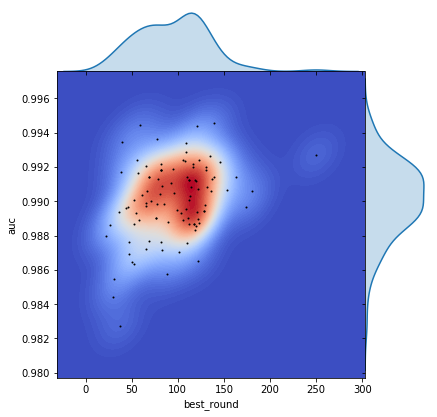

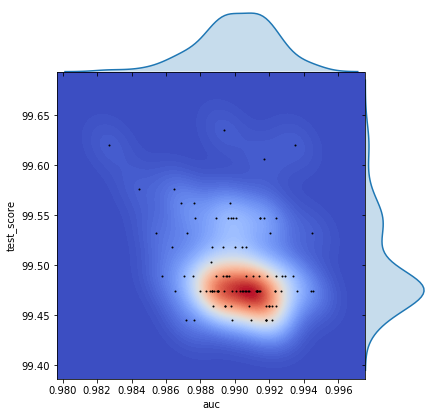

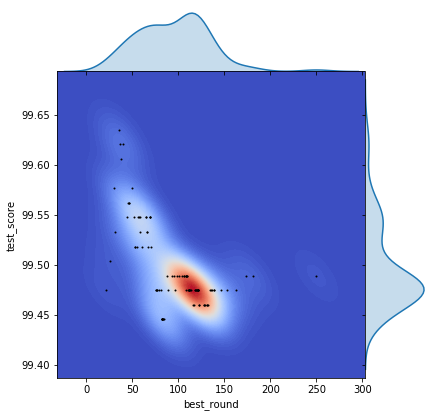

In [17]:
eval_cv_tests(params, train, test, max_rounds, nfold=5, metrics=['auc'], early_stop=20, n_times=100)

RUNNING 100x CV: 5-fold, 500(20) rounds, ['logloss'], {'objective': 'binary:logistic', 'max_depth': 3, 'learning_rate': 0.1, 'nthread': 4}
took 236.2 seconds
EVALUATING test set: ['logloss']
took 28.9 seconds


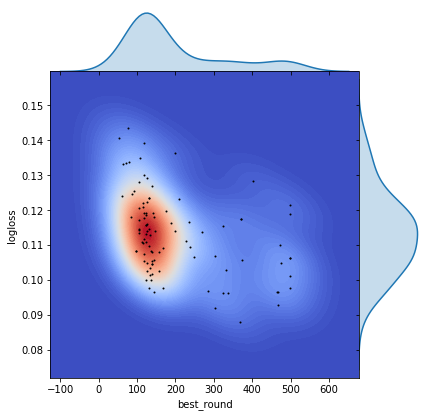

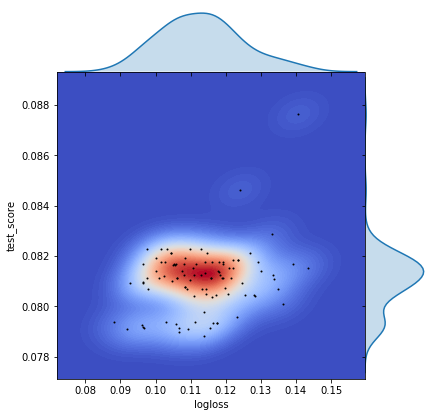

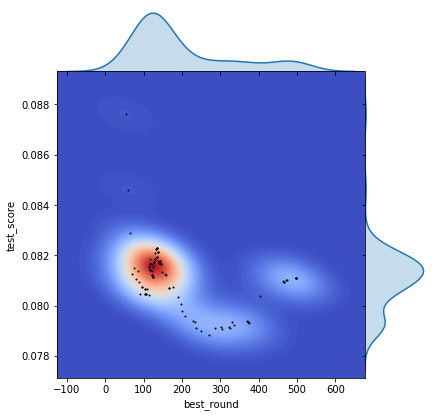

In [18]:
eval_cv_tests(params, train, test, max_rounds, nfold=5, metrics=['logloss'], early_stop=20, n_times=100)

## With Hyperparameter Optimization

In [22]:
from sklearn.model_selection import GridSearchCV

def xgb_grid_search(space, X_train, y_train, params, max_rounds, skb, random_seed):
    clf = XGBClassifier(n_estimators=max_rounds, **params, random_state=random_seed)
    
    scoring = ['roc_auc']

    #print(f"xgb_cv '{key}', shape={X.shape}")
    start = time()

    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=space,
        n_jobs=4,
        cv=skb,
        scoring=scoring,
        verbose=0,
        refit=scoring[0],
        return_train_score=False,
    )

    fit_gs = grid_search.fit(X_train, y_train)
    print(fit_gs.best_params_, fit_gs.best_score_)

search_space = {
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],  # subsample of observations
    "colsample_bytree": [0.8, 1.0],  # subsample of features
    "learning_rate": [0.1, 0.05],
}

params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
}

rs = np.random.RandomState(42)
start = time()
for i in range(10):
    random_seed = rs.randint(1000)
    skb = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    xgb_grid_search(search_space, X_train, y_train, params, max_rounds, skb, random_seed)
print("took %.1f seconds" % (time() - start))

{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8} 0.9934956391151157
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0} 0.9914884768670941
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'subsample': 1.0} 0.9905879974585572
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8} 0.9921411655981055
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0} 0.9932536244440594
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 1.0} 0.9952636746953156
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8} 0.9937520938023451
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8} 0.9937578698088143
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8} 0.9931080690810374
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.8} 0.994